In [1]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# installing the keras tuner
# reference - https://www.youtube.com/watch?v=OzLAdpqm35E&t=704s
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 26.8 MB/s 
     |████████████████████████████████| 1.6 MB 63.6 MB/s 


In [22]:
# import libraries
import tensorflow as tf
import timeit
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import time
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers
from keras.layers import CuDNNLSTM
from keras.layers import LSTM
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import MaxPooling1D
from keras.layers import Embedding
from keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import os
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.offline as py
import plotly.express as px
from plotly import tools
import plotly.figure_factory as ff
import warnings
from matplotlib import pyplot as plt
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

In [4]:
# unzip the dataset
import os
zip_path = os.path.join(os.path.join('drive', 'My Drive', 'Dissertation'), 'df_news_combined.csv.zip')
!cp '{zip_path}' .
!yes|unzip -q df_news_combined.csv.zip
!rm df_news_combined.csv.zip
print(os.listdir(os.path.join('drive', 'My Drive', 'Dissertation')))

['df_news_combined.csv.zip', 'trails.ipynb', 'naivebayes_base_and_tuned.ipynb', 'xgboost_base_and_tuned.ipynb', 'random_forest_base_and_tuned.ipynb', 'gru_base_and_tuned.ipynb', 'stochastic_gradient_descent_base_and_tuned', 'data_collection_and_data_cleaning.ipynb', 'data_visualisation.ipynb', 'mlp_base_and_tuned.ipynb', 'cnn_base_and_tuned.ipynb', 'lstm_base_and_tuned.ipynb']


In [5]:
# read the dataset
df_news_com = pd.read_csv('df_news_combined.csv')
df_news_com

,TITLE,ARTICLE LINK,AUTHOR,PUBLISHER,COUNTRY,CATEGORY,LANGUAGE,DESCRIPTION,IMAGE URL,VIDEO URL,DATE,GMT,POSTAG
0,"""Business duo turn over $70K a month with thei...",https://www.dailymail.co.uk/femail/article-107...,Unknown,Mail Online,United Kingdom,Food,English,business duo create home hair kit bridge gap b...,https://i.dailymail.co.uk/1s/2022/04/29/05/571...,Unknown,05/01/2022,00:16,"[('business', 'NN'), ('duo', 'NN'), ('created'..."
1,"""People Are Sharing ""Impulsive And Expensive"" ...",https://www.buzzfeed.com/fabianabuontempo/peop...,Unknown,Buzzfeed,United Kingdom,Food,English,definitely need love make confident secure hap...,https://img.buzzfeed.com/buzzfeed-static/stati...,Unknown,05/01/2022,00:25,"[('definitely', 'RB'), ('need', 'MD'), ('love'..."
2,"""Why You Shouldn't Butter The Pan When Making ...",https://www.buzzfeed.com/rossyoder/culinary-sc...,Unknown,Buzzfeed,United Kingdom,Food,English,class session view entire post,https://img.buzzfeed.com/buzzfeed-static/stati...,Unknown,05/01/2022,00:25,"[('class', 'NN'), ('session', 'NN'), ('view', ..."
3,"""Quaint beachside cottage on the Mornington Pe...",https://www.dailymail.co.uk/femail/homes/artic...,Unknown,Mail Online,United Kingdom,Food,English,ultra chic contemporary home lap pool tennis c...,https://i.dailymail.co.uk/1s/2022/04/29/07/571...,Unknown,05/01/2022,00:53,"[('ultra', 'JJ'), ('chic', 'JJ'), ('contempora..."
4,"""Viral Tiktok claims Sunnyboys were back at Wo...",https://www.dailymail.co.uk/femail/food/articl...,Unknown,Mail Online,United Kingdom,Food,English,australian shoppers send spin tiktok clip go v...,https://i.dailymail.co.uk/1s/2022/05/01/02/572...,Unknown,05/01/2022,01:32,"[('australian', 'JJ'), ('shoppers', 'NNS'), ('..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
823100,"""'New Zealand condemns Russias annexation atte...",http://www.voxy.co.nz/politics/5/407843,Unknown,Voxy,New Zealand,Politics,English,new zealand condemn unequivocally russias atte...,Unknown,Unknown,30/09/2022,23:02,"[('new', 'JJ'), ('zealand', 'NNP'), ('condemns..."
823101,"""Nigeria @ 62: So far, not so good""",https://punchng.com/nigeria-62-so-far-not-so-g...,Our Reporters,Punch,Nigeria,Politics,English,leke baiyewu abiodun sanusi x ray political hi...,Unknown,Unknown,30/09/2022,23:25,"[('leke', 'NN'), ('baiyewu', 'NN'), ('abiodun'..."
823102,"""Most Voters Say Trump Should Not Be Allowed T...",https://www.huffpost.com/entry/voters-donald-t...,Unknown,Huffpost,United States Of America,Politics,English,apparently go give know ongoing investigations...,Unknown,Unknown,30/09/2022,23:25,"[('apparently', 'RB'), ('go', 'VB'), ('given',..."
823103,"""Babayemi congratulates Adeleke on Supreme Cou...",https://punchng.com/babayemi-congratulates-ade...,Bola Bamigbola,Punch,Nigeria,Politics,English,former governorship aspirant platform people d...,Unknown,Unknown,30/09/2022,23:44,"[('former', 'JJ'), ('governorship', 'NN'), ('a..."


In [6]:
# reference - https://note.nkmk.me/en/python-pandas-nan-judge-count/
# checking for the missing values
df_news_com.isnull().sum()
# note - the reason this dataset is showing null values again beacause it is converted in the zip file, so the null values occured automatically even after doing the data cleaning.
# note - the code is been adapted from the reference and it is modified

TITLE            0
ARTICLE LINK     0
AUTHOR          27
PUBLISHER        0
COUNTRY          0
CATEGORY         0
LANGUAGE         0
DESCRIPTION     91
IMAGE URL        0
VIDEO URL        0
DATE             0
GMT              0
POSTAG           0
dtype: int64

In [7]:
# reference - https://www.geeksforgeeks.org/replace-nan-values-with-zeros-in-pandas-dataframe/
# replacing the null values with the unknown
df_news_com['AUTHOR'] = df_news_com['AUTHOR'].fillna('Unknown')
df_news_com['DESCRIPTION'] = df_news_com['DESCRIPTION'].fillna('Unknown')
# note - the code is been adapted from the reference and it is modified

In [8]:
# reference - https://note.nkmk.me/en/python-pandas-nan-judge-count/
# checking for the missing values
df_news_com.isnull().sum()
# note - the code is been adapted from the reference and it is modified

TITLE           0
ARTICLE LINK    0
AUTHOR          0
PUBLISHER       0
COUNTRY         0
CATEGORY        0
LANGUAGE        0
DESCRIPTION     0
IMAGE URL       0
VIDEO URL       0
DATE            0
GMT             0
POSTAG          0
dtype: int64

In [9]:
# getting the info
df_news_com.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823105 entries, 0 to 823104
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   TITLE         823105 non-null  object
 1   ARTICLE LINK  823105 non-null  object
 2   AUTHOR        823105 non-null  object
 3   PUBLISHER     823105 non-null  object
 4   COUNTRY       823105 non-null  object
 5   CATEGORY      823105 non-null  object
 6   LANGUAGE      823105 non-null  object
 7   DESCRIPTION   823105 non-null  object
 8   IMAGE URL     823105 non-null  object
 9   VIDEO URL     823105 non-null  object
 10  DATE          823105 non-null  object
 11  GMT           823105 non-null  object
 12  POSTAG        823105 non-null  object
dtypes: object(13)
memory usage: 81.6+ MB


In [10]:
# reference - https://www.folkstalk.com/tech/create-new-dataframe-from-existing-dataframe-pandas-with-code-examples/
# creating separate dataframe of columns description and category
df_news_com1 = df_news_com[['DESCRIPTION', 'CATEGORY']].copy()
df_news_com1.head()
# note - the code is been adapted from the reference and it is modified

,DESCRIPTION,CATEGORY
0,business duo create home hair kit bridge gap b...,Food
1,definitely need love make confident secure hap...,Food
2,class session view entire post,Food
3,ultra chic contemporary home lap pool tennis c...,Food
4,australian shoppers send spin tiktok clip go v...,Food


In [11]:
# reference - https://www.geeksforgeeks.org/ml-label-encoding-of-datasets-in-python/
# label encoding the categories
label_encoder_category = preprocessing.LabelEncoder()
df_news_com1['CATEGORY']= label_encoder_category.fit_transform(df_news_com1['CATEGORY'])
df_news_com1.head()
# note - the code is been adapted from the reference and it is modified

,DESCRIPTION,CATEGORY
0,business duo create home hair kit bridge gap b...,3
1,definitely need love make confident secure hap...,3
2,class session view entire post,3
3,ultra chic contemporary home lap pool tennis c...,3
4,australian shoppers send spin tiktok clip go v...,3


In [12]:
# reference - https://www.folkstalk.com/2022/10/number-of-total-words-in-cell-pandas-with-code-examples.html
# added the column sentence length which shows the length of the sentence
df_news_com1['SENTENCE_LENGTH'] = df_news_com1['DESCRIPTION'].apply(lambda x:len(str(x).split())) 
sentence_length_max = df_news_com1['SENTENCE_LENGTH'].max()
sentence_length_max
# note - the code is been adapted from the reference and it is modified

3732

### LSTM Base Model

In [13]:
# reference - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# reference - https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
# this class makes it possible to "vectorize" a body of text by converting it into a series of numbers.
maximum_num_words = 10000
tokenizer = Tokenizer(num_words = maximum_num_words)
tokenizer.fit_on_texts(df_news_com1['DESCRIPTION'].values)
# note - the code is been adapted from the references and it is modified

In [14]:
# reference - https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
# reference - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# this class makes it possible to "vectorize" a body of text by converting it into a series of numbers.
x_lstm = tokenizer.texts_to_sequences(df_news_com1['DESCRIPTION'].values)
x_lstm = pad_sequences(x_lstm, maxlen=3800)
# note - the code is been adapted from the reference and it is modified

In [15]:
# get the shape of the input side
x_lstm.shape

(823105, 3800)

In [16]:
# reference -https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
# values of the categories
y_lstm = pd.get_dummies(df_news_com1['CATEGORY']).values
# note - the code is been adapted from the reference and it is modified

In [17]:
# get the shape of the output side
y_lstm.shape

(823105, 7)

In [18]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# splitting into training and testing
x_train_lstm, x_test_lstm, y_train_lstm, y_test_lstm = train_test_split(x_lstm, y_lstm, test_size=0.2, shuffle = False , random_state = 0)
# note - the code is been adapted from the reference and it is modified

In [19]:
# create the lstm base model
# reference - https://analyticsindiamag.com/a-complete-guide-to-lstm-architecture-and-its-use-in-text-classification/#:~:text=Text%20classification%20using%20LSTM,-In%20this%20section&text=In%20the%20modelling%2C%20we%20are,memory%20unit%20of%20the%20model.
# reference - https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
# reference - https://www.analyticsvidhya.com/blog/2021/06/lstm-for-text-classification/
# reference - https://www.analyticsvidhya.com/blog/2021/10/emotion-detection-using-bidirectional-lstm-and-word2vec/
# reference - https://faroit.com/keras-docs/0.3.3/examples/
# reference - https://www.programcreek.com/python/example/120292/keras.layers.CuDNNLSTM
embedding_dim = 128
feature_size = 15000
model_lstm = Sequential()
model_lstm.add(layers.Embedding( feature_size,embedding_dim, input_length=x_lstm.shape[1])) # embedding layer with feature size, embedding dimension and input length
model_lstm.add(Dropout(0.1)) # first dropout layer
model_lstm.add(CuDNNLSTM(128)) # CuDNNLSTM layer
model_lstm.add(Dense(64, activation = 'relu')) # first dense layer
model_lstm.add(Dropout(0.1)) # second dropout layer
model_lstm.add(Dense(7, activation='softmax')) # second dene layer
model_lstm.summary()
# note - the code is been adapted from the references and it is modified

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3800, 128)         1920000   
                                                                 
 dropout (Dropout)           (None, 3800, 128)         0         
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 128)               132096    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 2,060,807
Trainable params: 2,060,807
Non-

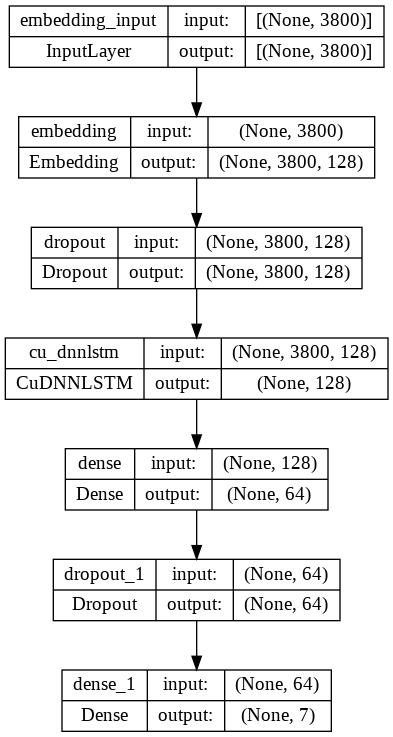

In [20]:
# reference - https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
# print the lstm base model
plot_model(model_lstm, to_file='model_plot_lstm.png', show_shapes=True, show_layer_names=True)
# note - the code is been adapted from the reference and it is modified.

In [21]:
# reference - https://analyticsindiamag.com/a-complete-guide-to-lstm-architecture-and-its-use-in-text-classification/#:~:text=Text%20classification%20using%20LSTM,-In%20this%20section&text=In%20the%20modelling%2C%20we%20are,memory%20unit%20of%20the%20model.
# reference - https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
# reference - https://www.analyticsvidhya.com/blog/2021/06/lstm-for-text-classification/
# reference - https://www.analyticsvidhya.com/blog/2021/10/emotion-detection-using-bidirectional-lstm-and-word2vec/
# reference - https://faroit.com/keras-docs/0.3.3/examples/
# reference - https://www.programcreek.com/python/example/120292/keras.layers.CuDNNLSTM
# applying the the loss, otimizer and training the model
model_lstm.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
lstm_start_time = time.time()
model_lstm_history = model_lstm.fit(x_train_lstm, y_train_lstm,
                     epochs=5,
                     verbose=False,
                     validation_split=0.1,
                     batch_size=512,callbacks=[EarlyStopping(patience=100)])
lstm_stop_time = time.time()
# note - the code is been adapted from the references and it is modified
# note - the parameters of the models are randomly chosen

In [23]:
# training loss and accuracy of the lstm base model
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
loss, accuracy = model_lstm.evaluate(x_train_lstm, y_train_lstm)

20578/20578 [==============================] - 1305s 63ms/step - loss: 0.1917 - accuracy: 0.9354


In [24]:
# reference - https://plotly.com/python/line-and-scatter/
# reference - https://plotly.com/python/reference/layout/
# reference - https://www.kaggle.com/code/sercanyesiloz/plotly-tutorial/notebook#Line%20Charts
# reference - https://linuxhint.com/plotly-graph-objects-scatter/
# plotting the training loss
lstm_model_training_loss = model_lstm_history.history['loss']
epochs = [1,2,3,4,5]
df_model_lstm_history = go.Scatter(x = epochs,
                     y = lstm_model_training_loss ,
                     mode="markers+lines",
                     marker = dict(color = 'red'))
lstm_layout = go.Layout(title={'text' : 'LSTM MODEL TRAINING LOSS'},xaxis=dict(title = 'EPOCHS'),yaxis=dict(title='TRAINING LOSS'),
                   template = 'plotly_dark')


fig = go.Figure(data = df_model_lstm_history,layout=lstm_layout)
fig.update_layout(width=500,
    height=500
)
iplot(fig)
# note - the code is been adapted from the references and it is modified

In [26]:
# reference - https://plotly.com/python/line-and-scatter/
# reference - https://plotly.com/python/reference/layout/
# reference - https://www.kaggle.com/code/sercanyesiloz/plotly-tutorial/notebook#Line%20Charts
# reference - https://linuxhint.com/plotly-graph-objects-scatter/
# plotting the training accuracy
lstm_model_training_accuracy = model_lstm_history.history['accuracy']
epochs = [1,2,3,4,5]
df_model_lstm_history = go.Scatter(x = epochs,
                     y = lstm_model_training_accuracy ,
                     mode="markers+lines",
                     marker = dict(color = 'limegreen'))
lstm_layout = go.Layout(title={'text' : 'LSTM MODEL TRAINING ACCURACY'},xaxis=dict(title = 'EPOCHS'),yaxis=dict(title='TRAINING ACCURACY'),
                   template = 'plotly_dark')

fig = go.Figure(data = df_model_lstm_history,layout=lstm_layout)
fig.update_layout(width=500,
    height=500
)
iplot(fig)
# note - the code is been adapted from the references and it is modified



In [27]:
# predict the lstm base model
lstm_train_predict = model_lstm.predict(x_train_lstm)

20578/20578 [==============================] - 1299s 63ms/step


In [28]:
# reference - https://datascience.stackexchange.com/questions/93751/valueerror-classification-metrics-cant-handle-a-mix-of-multilabel-indicator-an
y_train_lstm_arg=np.argmax(y_train_lstm,axis=1)
y_train_pred_lstm = np.argmax(lstm_train_predict,axis=1)
# note - the code is been adapted from the references and it is modified
# note - I added this code because I was getting the value error of mix multilabel

### Training side of lstm model : getting precision,recall,f1,fbeta,mae,mse,rmse,training time

In [29]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
# generating the classification report
from sklearn import metrics
print(metrics.classification_report(y_train_lstm_arg, y_train_pred_lstm))
# note - the code is been adapted from the references and it is modified

              precision    recall  f1-score   support

           0       0.91      0.94      0.92    184194
           1       0.95      0.86      0.90    145217
           3       0.68      0.56      0.61      3756
           4       0.85      0.85      0.85     40210
           6       0.96      0.99      0.97    285107

    accuracy                           0.94    658484
   macro avg       0.87      0.84      0.85    658484
weighted avg       0.94      0.94      0.93    658484



In [30]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
# calculate the precision score
print(precision_score(y_train_lstm_arg, y_train_pred_lstm,average='macro'))
# note - the code is been adapted from the references and it is modified

0.8703031151331352


In [31]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
# calculate the recall score
print(recall_score(y_train_lstm_arg, y_train_pred_lstm,average='macro'))
# note - the code is been adapted from the references and it is modified

0.8399448822608232


In [32]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# calculate the f1 score
print(f1_score(y_train_lstm_arg, y_train_pred_lstm,average='macro'))
# note - the code is been adapted from the references and it is modified

0.8534286036559825


In [33]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html
# calculate the fbeta score
print(fbeta_score(y_train_lstm_arg, y_train_pred_lstm,average='macro', beta = 0.7))
# note - the code is been adapted from the references and it is modified

0.8587801686503578


In [34]:
# calculate the MSE
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
print(mean_squared_error(y_train_lstm_arg, y_train_pred_lstm,squared=True))
# note - the code is been adapted from the references and it is modified

0.935108521999016


In [35]:
# calculate the RMSE
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
print(mean_squared_error(y_train_lstm_arg, y_train_pred_lstm,squared=False))
# note - the code is been adapted from the references and it is modified

0.9670100940522885


In [40]:
# calculate the train time
training_time_lstm = lstm_stop_time - lstm_start_time
training_time_lstm

1589.586145401001

### Testing side of lstm model : getting precision,recall,f1,fbeta,mae,mse,rmse

In [36]:
# testing loss and accuracy of the lstm base model
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
loss, accuracy = model_lstm.evaluate(x_test_lstm, y_test_lstm)

5145/5145 [==============================] - 328s 64ms/step - loss: 5.1839 - accuracy: 0.5782


In [37]:
# predict the lstm base model
lstm_test_predict = model_lstm.predict(x_test_lstm)

5145/5145 [==============================] - 326s 63ms/step


In [38]:
# reference - https://datascience.stackexchange.com/questions/93751/valueerror-classification-metrics-cant-handle-a-mix-of-multilabel-indicator-an
y_test_lstm_arg=np.argmax(y_test_lstm,axis=1)
y_test_pred_lstm = np.argmax(lstm_test_predict,axis=1)
# note - the code is been adapted from the references and it is modified
# note - I added this code because I was getting the value error of mix multilabel

In [39]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
# generating the classification report
from sklearn import metrics
print(metrics.classification_report(y_test_lstm_arg, y_test_pred_lstm))
# note - the code is been adapted from the references and it is modified

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.93      0.80      0.86    119609
           2       0.00      0.00      0.00      7281
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00     37731
           6       0.00      0.00      0.00         0

    accuracy                           0.58    164621
   macro avg       0.13      0.11      0.12    164621
weighted avg       0.68      0.58      0.62    164621



In [41]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
# calculate the precision score
print(precision_score(y_test_lstm_arg, y_test_pred_lstm,average='macro'))
# note - the code is been adapted from the references and it is modified

0.13274062297345354


In [42]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
# calculate the recall score
print(recall_score(y_test_lstm_arg, y_test_pred_lstm,average='macro'))
# note - the code is been adapted from the references and it is modified

0.11368112528560322


In [43]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# calculate the f1 score
print(f1_score(y_test_lstm_arg, y_test_pred_lstm,average='macro'))
# note - the code is been adapted from the references and it is modified

0.12247379541249225


In [44]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html
# calculate the fbeta score
print(fbeta_score(y_test_lstm_arg, y_test_pred_lstm,average='macro', beta = 0.7))
# note - the code is been adapted from the references and it is modified

0.12580431396904546


In [45]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
# calculate the MAE
print(mean_absolute_error(y_test_lstm_arg, y_test_pred_lstm))
# note - the code is been adapted from the references and it is modified

1.3995723510366236


In [46]:
# calculate the MSE
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
print(mean_squared_error(y_test_lstm_arg, y_test_pred_lstm,squared=True))
# note - the code is been adapted from the references and it is modified

5.9742985402834385


In [47]:
# calculate the RMSE
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
print(mean_squared_error(y_test_lstm_arg, y_test_pred_lstm,squared=False))
# note - the code is been adapted from the references and it is modified

2.444237824002288


### LSTM Tuned Model

In [48]:
# define the model for the hyperparameters
def create_model(hyper_para):
  lstm_model_tuned = keras.Sequential()
  lstm_model_tuned.add(layers.Embedding(input_dim = hyper_para.Int('input_dim', min_value = 15000,max_value = 20000 , step = 5000 ),output_dim = hyper_para.Int('output_dim',min_value=100,max_value=200,step = 100),input_length = x_lstm.shape[1] ))
  lstm_model_tuned.add(Dropout(0.1))
  lstm_model_tuned.add(CuDNNLSTM(128))
  lstm_model_tuned.add(layers.Dense(units=hyper_para.Int('units',min_value = 128, max_value = 256, step = 128),activation = 'relu'))
  lstm_model_tuned.add(Dropout(0.1))
  lstm_model_tuned.add(layers.Dense(7, activation='softmax'))
  lstm_model_tuned.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(hyper_para.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])),metrics=['accuracy'])
  return lstm_model_tuned
# note - the code is been created from my cnn program as per the lstm model


### LSTM Tuning with Hyperband

In [49]:
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tune
# referencesc - https://keras.io/api/keras_tuner/tuners/hyperband/
from kerastuner.tuners import Hyperband
lstm_hyperband_tuner = Hyperband(
    create_model,
    max_epochs= 1,
    hyperband_iterations=1,
    overwrite = True,
    objective = 'accuracy',
    factor = 2
)
lstm_hyperband_tuner.search_space_summary()
# note - the code is been adapted from the references and it is modified

Search space summary
Default search space size: 4
input_dim (Int)
{'default': None, 'conditions': [], 'min_value': 15000, 'max_value': 20000, 'step': 5000, 'sampling': None}
output_dim (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 200, 'step': 100, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 128, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [50]:
# reference - https://www.youtube.com/watch?v=6Nf1x7qThR8&t=444s
# create the earlystopping
early_stop_lstm = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy',patience=100)
# note - the code is been adapted from the references and it is modified

In [51]:
# reference - https://www.youtube.com/watch?v=6Nf1x7qThR8&t=444s
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tune
# reference - https://keras.io/api/keras_tuner/tuners/hyperband/
# searching for best hyperparameters
lstm_hyperband_tuner.search(x_train_lstm, y_train_lstm, epochs=1, validation_split=0.1, callbacks=[early_stop_lstm],batch_size=512)
# note - the code is been adapted from the references and it is modified
# note - parameters are randomly chosen
# note - epoch only chosen 1 because the session was crashing repeatedly as the cudnnlstm require huge amount of ram

Trial 1 Complete [00h 06m 24s]
accuracy: 0.8821061849594116

Best accuracy So Far: 0.8821061849594116
Total elapsed time: 00h 06m 24s


In [52]:
# reference - https://www.youtube.com/watch?v=6Nf1x7qThR8&t=444s
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
# best hyperparameters
best_hyperparameters_lstm = lstm_hyperband_tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters_lstm.values
# note - the code is been adapted from the references and it is modified

{'input_dim': 20000,
 'output_dim': 200,
 'units': 256,
 'learning_rate': 0.001,
 'tuner/epochs': 1,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [54]:
# creating 1st lstm model(epochs=10 and batch_size=512) with best hyperparameters
model_lstm_tuned1 = lstm_hyperband_tuner.hypermodel.build(best_hyperparameters_lstm)
model_lstm_tuned1_history = model_lstm_tuned1.fit(x_train_lstm, y_train_lstm,validation_split=0.1,
                     epochs=10,
                     verbose=False,
                     batch_size=512,callbacks=[EarlyStopping(monitor = 'accuracy',patience=100)])
# note - the code is been created from my cnn program as per the lstm model

In [55]:
# training loss and accuracy of the 1st tuned lstm model
loss, accuracy = model_lstm_tuned1.evaluate(x_train_lstm, y_train_lstm)
# note - the code is been created from my cnn program as per the lstm model

20578/20578 [==============================] - 1464s 71ms/step - loss: 0.1616 - accuracy: 0.9612


In [56]:
# testing loss and accuracy of the 1st tuned lstm model
loss, accuracy = model_lstm_tuned1.evaluate(x_test_lstm, y_test_lstm)
# note - the code is been created from my cnn program as per the lstm model

5145/5145 [==============================] - 367s 71ms/step - loss: 10.4149 - accuracy: 0.5387


In [57]:
# creating 2nd lstm model(epochs=15 and batch_size=512) with best hyperparameters
model_lstm_tuned2 = lstm_hyperband_tuner.hypermodel.build(best_hyperparameters_lstm)
model_lstm_tuned2_history = model_lstm_tuned2.fit(x_train_lstm, y_train_lstm,validation_split=0.1,
                     epochs=15,
                     verbose=False,
                     batch_size=512,callbacks=[EarlyStopping(monitor = 'accuracy',patience=100)])
# note - the code is been created from my cnn program as per the lstm model

In [58]:
# training loss and accuracy of the 1st tuned lstm model
loss, accuracy = model_lstm_tuned2.evaluate(x_train_lstm, y_train_lstm)
# note - the code is been created from my cnn program as per the lstm model

20578/20578 [==============================] - 1473s 72ms/step - loss: 0.1876 - accuracy: 0.9730


In [59]:
# testing loss and accuracy of the 2nd tuned lstm model
loss, accuracy = model_lstm_tuned2.evaluate(x_test_lstm, y_test_lstm)
# note - the code is been created from my cnn program as per the lstm model

5145/5145 [==============================] - 370s 72ms/step - loss: 14.0141 - accuracy: 0.5473


### LSTM Tuning with random search

In [60]:
# reference - https://www.sicara.fr/blog-technique/hyperparameter-tuning-keras-tuner
# reference - https://keras.io/api/keras_tuner/tuners/random/
from kerastuner.tuners import RandomSearch
lstm_randomsearch_tuner = RandomSearch(
    create_model,
    max_trials=3,
    objective='accuracy',
)
lstm_randomsearch_tuner.search_space_summary()
# note - the code is been adapted from the reference and it is modified

Search space summary
Default search space size: 4
input_dim (Int)
{'default': None, 'conditions': [], 'min_value': 15000, 'max_value': 20000, 'step': 5000, 'sampling': None}
output_dim (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 200, 'step': 100, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 128, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [61]:
# reference - https://www.youtube.com/watch?v=6Nf1x7qThR8&t=444s
# create the earlystopping
early_stop_lstm1 = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy',patience=100)
# note - the code is been adapted from the reference and it is modified

In [62]:
# searching for best hyperparameters
lstm_randomsearch_tuner.search(x_train_lstm, y_train_lstm, epochs=1, validation_split=0.1, callbacks=[early_stop_lstm1],batch_size=512)
# note - the code is been created from my cnn program as per the lstm model

Trial 3 Complete [00h 06m 04s]
accuracy: 0.769417941570282

Best accuracy So Far: 0.8971947431564331
Total elapsed time: 00h 11m 46s


In [63]:
# best hyperparameters
best_hyperparameters_lstm1 = lstm_randomsearch_tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters_lstm1.values
# note - the code is been created from my cnn program as per the lstm model

{'input_dim': 20000, 'output_dim': 200, 'units': 256, 'learning_rate': 0.01}

In [65]:
# creating 3rd lstm model(epochs=10 and batch_size=512) with best hyperparameters
model_lstm_tuned3 = lstm_randomsearch_tuner.hypermodel.build(best_hyperparameters_lstm1)
model_lstm_tuned3_history = model_lstm_tuned3.fit(x_train_lstm, y_train_lstm,validation_split=0.1,
                     epochs=10,
                     verbose=False,
                     batch_size=512,callbacks=[EarlyStopping(monitor = 'accuracy',patience=100)])
# note - the code is been created from my cnn program as per the lstm model

In [66]:
# training loss and accuracy of the 3rd tuned lstm model
loss, accuracy = model_lstm_tuned3.evaluate(x_train_lstm, y_train_lstm)
# note - the code is been created from my cnn program as per the lstm model

20578/20578 [==============================] - 1482s 72ms/step - loss: 0.2378 - accuracy: 0.9210


In [67]:
# testing loss and accuracy of the 3rd tuned lstm model
loss, accuracy = model_lstm_tuned3.evaluate(x_test_lstm, y_test_lstm)
# note - the code is been created from my cnn program as per the lstm model

5145/5145 [==============================] - 370s 72ms/step - loss: 17.7909 - accuracy: 0.5679


In [68]:
# creating 4th lstm model(epochs=15 and batch_size=512) with best hyperparameters
model_lstm_tuned4 = lstm_randomsearch_tuner.hypermodel.build(best_hyperparameters_lstm1)
model_lstm_tuned4_history = model_lstm_tuned4.fit(x_train_lstm, y_train_lstm,validation_split=0.1,
                     epochs=15,
                     verbose=False,
                     batch_size=512,callbacks=[EarlyStopping(monitor = 'accuracy',patience=100)])
# note - the code is been created from my cnn program as per the lstm model

In [69]:
# training loss and accuracy of the 4th tuned lstm model
loss, accuracy = model_lstm_tuned4.evaluate(x_train_lstm, y_train_lstm)
# note - the code is been created from my cnn program as per the lstm model

20578/20578 [==============================] - 1493s 73ms/step - loss: 0.2446 - accuracy: 0.9185


In [70]:
# testing loss and accuracy of the 4th tuned lstm model
loss, accuracy = model_lstm_tuned4.evaluate(x_test_lstm, y_test_lstm)
# note - the code is been created from my cnn program as per the lstm model

5145/5145 [==============================] - 376s 73ms/step - loss: 28.4664 - accuracy: 0.5556
